# Shop Customer Data

The goal of this project is to create a customer segmentation by leveraging unsupervised learning model so that the business people can have a better understanding of its customer

The dataset is from Kaggle (link:https://www.kaggle.com/datasets/datascientistanna/customers-dataset)

## 1. Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
from gap_statistic import OptimalK
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### 1.1 Load Data

In [2]:
custo = pd.read_csv('./Customers.csv')

In [3]:
custo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              2000 non-null   int64 
 1   Gender                  2000 non-null   object
 2   Age                     2000 non-null   int64 
 3   Annual Income ($)       2000 non-null   int64 
 4   Spending Score (1-100)  2000 non-null   int64 
 5   Profession              1965 non-null   object
 6   Work Experience         2000 non-null   int64 
 7   Family Size             2000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 125.1+ KB


### 1.2 Check Missing Value

In [4]:
# Missing value count
custo.isna().sum()

CustomerID                 0
Gender                     0
Age                        0
Annual Income ($)          0
Spending Score (1-100)     0
Profession                35
Work Experience            0
Family Size                0
dtype: int64

In [5]:
# Missing value percentage
custo.isnull().mean() * 100

CustomerID                0.00
Gender                    0.00
Age                       0.00
Annual Income ($)         0.00
Spending Score (1-100)    0.00
Profession                1.75
Work Experience           0.00
Family Size               0.00
dtype: float64

### 1.3 Fill Missing Value

In [6]:
# Since the percentage of missing value is only 1.75%, we can use mode (for categorical data) to compute missing data
custo['Profession'] = custo['Profession'].fillna(custo['Profession'].mode())

### 1.4 Check Duplicates

In [7]:
custo.duplicated().sum()

0

## 2. Data Visualization

### 2.1 Histogram Of Each Column

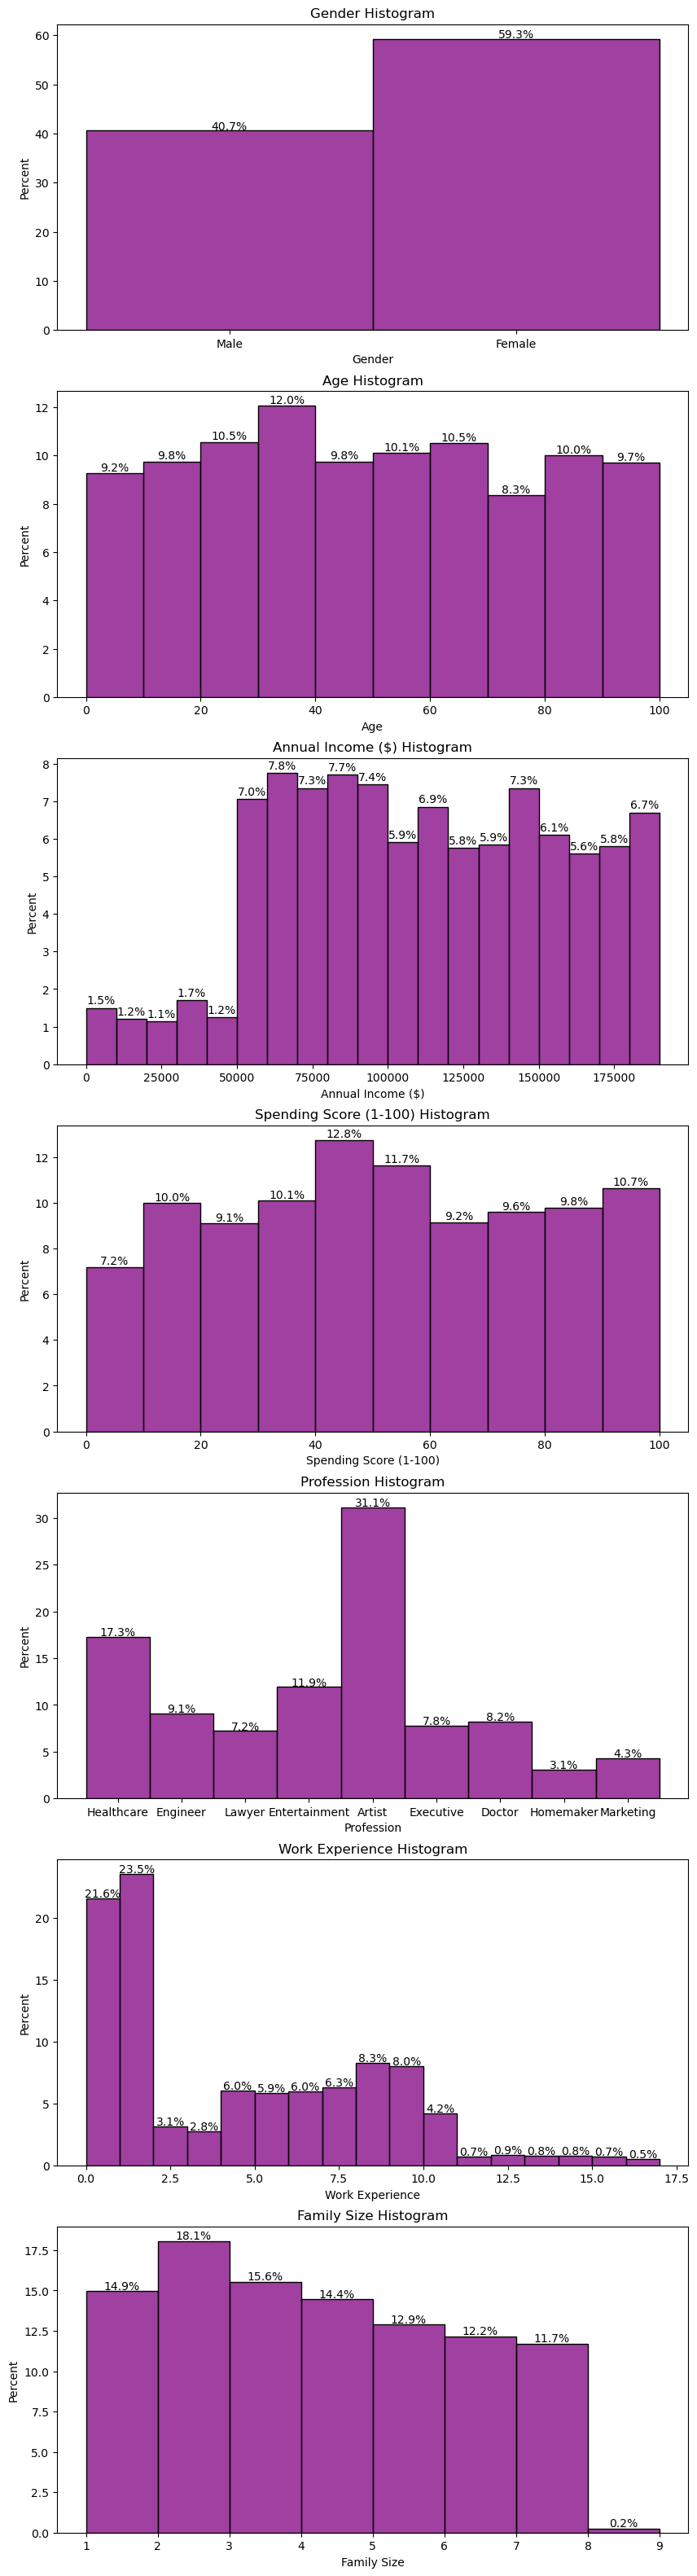

In [8]:
# Create a histogram and show as percentage for each column to better understand the data (exclude CustomerID)
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 40))
bin_map = dict(zip(custo.columns[1:].tolist(),[1,10,10000,10,1,1,1]))
for i,j in enumerate(custo.columns[1:]):
    ax = sns.histplot(custo[j],ax=axes[i],stat='percent',color="purple",binwidth = bin_map[j])
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', xy=(p.get_x() + p.get_width() / 2, p.get_height()+0.1),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='center')
    axes[i].set_title(j+' Histogram')

plt.show()

Based on the plot, we can see that:
1. Gender: Male (40.7%) vs Female (59.3%), Female are more likely to shop
2. Age: Distribution across age group is pretty even
3. Annual Income: About 93.3% of the customer make more than 50000 per year
4. Spending Score (1-100): Distribution across score range is pretty even
5. Profession: Total 9 profression where the highest is Artist about 31.1%, and the lowest is Homemaker about 3.1%
6. Work Experience: Data is bit right skewed where 45.1% of customer has less than 2 years of work experience.

<AxesSubplot:>

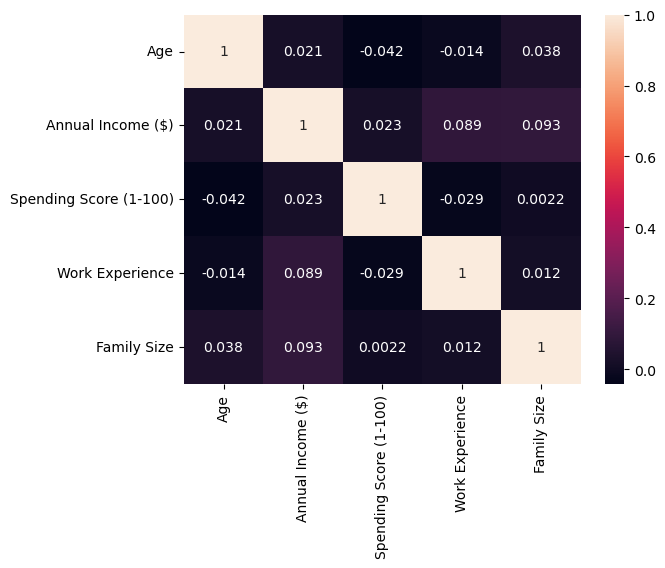

In [9]:
# Create a heatmap of correlation for numberic columns (exclude CustomerID)
num_col = ['Age', 'Annual Income ($)', 'Spending Score (1-100)',
           'Work Experience', 'Family Size']
sns.heatmap(custo[num_col].corr(), annot=True)

Based on the plot, we can see that:
1. Annual Income vs Work Experience/Family Size are positive correlated
2. Spending Score vs Age are negative correlated

## 3. Feature Engineering

### 3.1 Drop Redundant Columns

In [10]:
#We can drop CustomerID column since it is just an Id and it won't contribute much to the model
custo = custo.drop(columns=['CustomerID'])

### 3.2 Convert Categorical Columns to Numeric Columns

In [11]:
# Use labelencoder to convert categorical columns to numeric
custo['Gender'] = LabelEncoder().fit_transform(custo['Gender'])
custo['Profession'] = LabelEncoder().fit_transform(custo['Profession'])

### 3.3 Standarlized Data

In [12]:
# Since each of our columns has different scales, we need to standarlized the data to ensure that the result are 
# meaningful, interpretable, and not biased.
scaler = StandardScaler()
scaled_custo = scaler.fit_transform(custo)

## 4. Modeling

### 4.1 Find Most Optimal Number Of Cluster (Elbow Method)

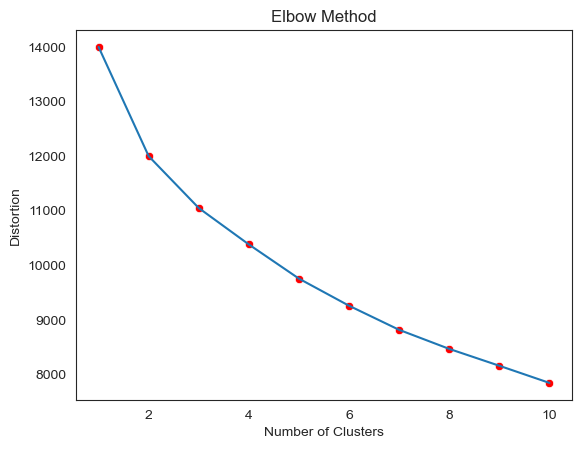

In [13]:
ss = []
for i in range(1, 11):
    model = KMeans(n_clusters=i, random_state=9)
    model.fit(scaled_custo)
    ss.append(model.inertia_)

sns.set_style("white")
sns.lineplot(x=list(range(1, 11)), y=ss)
sns.scatterplot(x=list(range(1, 11)), y=ss, color="red")
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

### 4.2 Find Most Optimal Number Of Cluster (Silhouette Score)

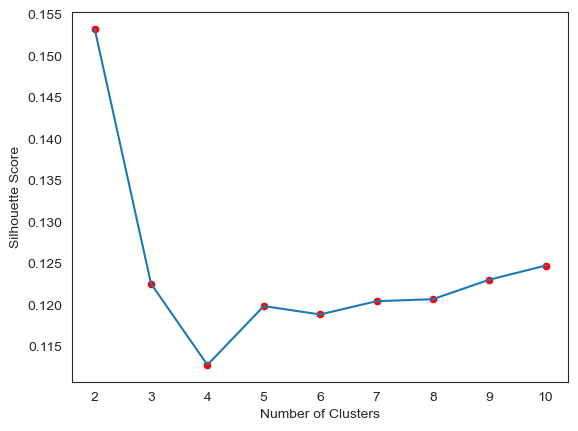

In [14]:
sil = []
for k in range(2, 11):
    model = KMeans(n_clusters=k, random_state=0)
    cluster_labels = model.fit_predict(scaled_custo)
    sil.append(silhouette_score(scaled_custo, cluster_labels))

sns.lineplot(x=list(range(2, 11)), y=sil)
sns.scatterplot(x=list(range(2, 11)), y=sil, color="red")
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

### 4.3 Find Most Optimal Number Of Cluster (Gap Statistics)

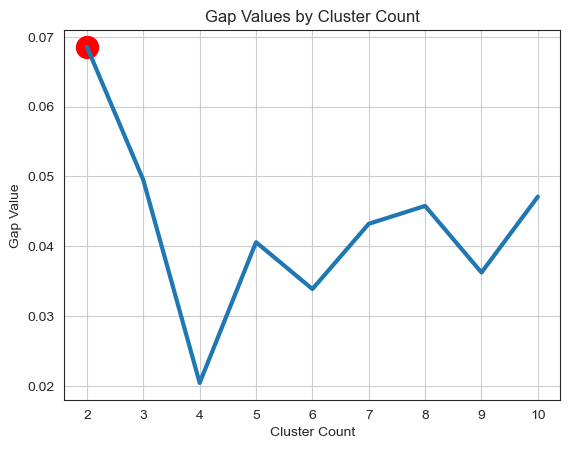

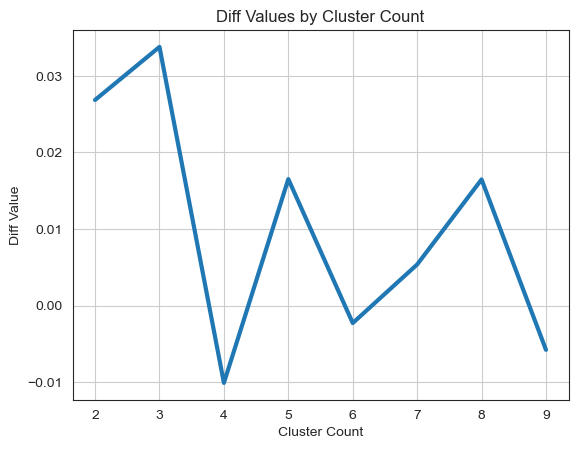

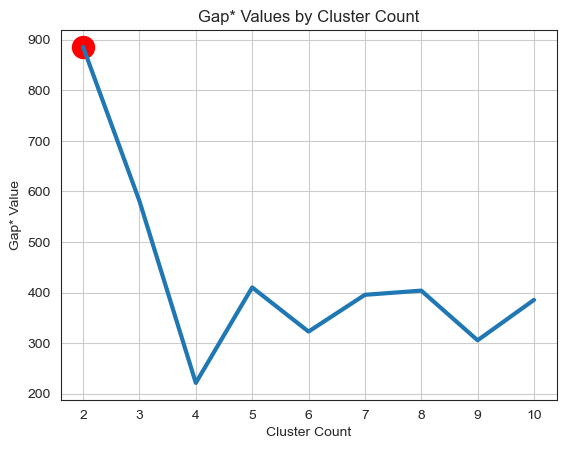

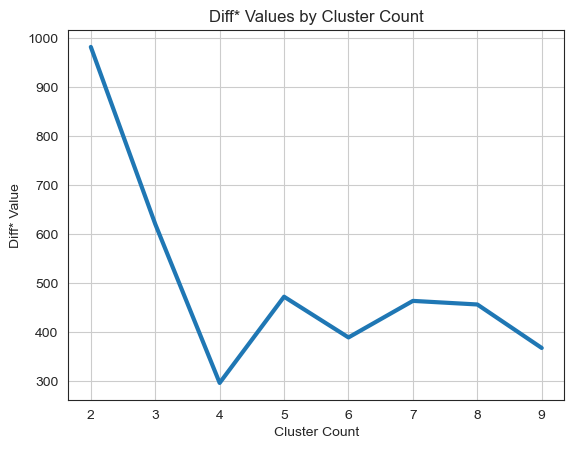

In [15]:
gap_s = OptimalK()
gap_v = gap_s(scaled_custo, cluster_array=range(2,11))
gap_s.plot_results()

Based on all three methods, 2 seems to be a good number of cluster to start, 3,4,5 can also be an option

In [16]:
def model_pred(n,model,data):
    if model == 'Kmeans':
        kmeans = KMeans(n_clusters=n, random_state=9)
        kmeans.fit(data)
        pred = kmeans.predict(data)
    elif model == 'Agglomerative':
        agg = AgglomerativeClustering(n_clusters=n)
        agg.fit(data)
        pred = agg.labels_
    elif model == 'GAM':
        gmm = GaussianMixture(n_components=n, random_state=9)
        gmm.fit(data)
        pred = gmm.predict(data)
    elif model == 'Spectral':
        sc = SpectralClustering(n_clusters=n, random_state=9)
        sc.fit(data)
        pred = sc.labels_
    return pred

### 4.4 Kmeans

It is a clustering algorithm that partitions data into K number of clusters. It iteratively optimizes the cluster centers to minimize the sum of squared distances between each data point and its assigned cluster center.

In [17]:
k_pred = model_pred(n=2,model='Kmeans',data=scaled_custo)

### 4.5 Agglomerative

It is a hierarchical clustering algorithm that starts with each data point as a separate cluster and iteratively merges the closest clusters until a stopping criterion is met. The stopping criterion can be a fixed number of clusters or a distance threshold.

In [18]:
a_pred = model_pred(n=2,model='Agglomerative',data=scaled_custo)

### 4.6 GAM

It is a probabilistic clustering algorithm that assumes data points are generated from a mixture of Gaussian distributions. GMM assigns probabilities to each data point for being in each of the K clusters and optimizes the model parameters to maximize the likelihood of the observed data.

In [19]:
g_pred = model_pred(n=2,model='GAM',data=scaled_custo)

### 4.7 Spectral

It is a graph-based clustering algorithm that partitions data based on the eigenvectors of the similarity matrix. Spectral clustering first constructs a similarity matrix between data points and then applies dimensionality reduction using the eigenvectors of the matrix. It then applies Kmeans clustering on the reduced-dimensional space.

In [20]:
s_pred = model_pred(n=2,model='Spectral',data=scaled_custo)

## 5. Evaluation

### 5.1 Model Comparison

In [21]:
# Use Davies-Bouldin Index to evaluate model performance
# The Davies-Bouldin index measures the similarity between clusters.the lower the score, the better the performance
mod = ['Kmeans','Agglomerative','GAM','Spectral']
k_acc = davies_bouldin_score(scaled_custo, k_pred)
a_acc = davies_bouldin_score(scaled_custo, a_pred)
g_acc = davies_bouldin_score(scaled_custo, g_pred)
s_acc = davies_bouldin_score(scaled_custo, s_pred)
eva = [k_acc,a_acc,g_acc,s_acc]
final_result = pd.DataFrame({'Model':mod,'N_Cluster':2,'Metric':'Davies-Bouldin Index','Score':eva})

In [22]:
final_result

,Model,N_Cluster,Metric,Score
0,Kmeans,2,Davies-Bouldin Index,2.353286
1,Agglomerative,2,Davies-Bouldin Index,2.353286
2,GAM,2,Davies-Bouldin Index,2.765094
3,Spectral,2,Davies-Bouldin Index,2.353286


### 5.2 Hyperparameter Tuning

In [23]:
# Try different number of clusters
ncls = [3,4,5]
for i in ncls:
    for j in mod:
        my_pred = model_pred(n=i,model=j,data=scaled_custo)
        my_acc = davies_bouldin_score(scaled_custo,my_pred)
        new_df = pd.DataFrame({'Model':j,'N_Cluster':i,'Metric':'Davies-Bouldin Index','Score':my_acc},index=[0])
        final_result = pd.concat([final_result,new_df],ignore_index=True)

In [24]:
final_result

,Model,N_Cluster,Metric,Score
0,Kmeans,2,Davies-Bouldin Index,2.353286
1,Agglomerative,2,Davies-Bouldin Index,2.353286
2,GAM,2,Davies-Bouldin Index,2.765094
3,Spectral,2,Davies-Bouldin Index,2.353286
4,Kmeans,3,Davies-Bouldin Index,2.298836
5,Agglomerative,3,Davies-Bouldin Index,2.733743
6,GAM,3,Davies-Bouldin Index,2.532586
7,Spectral,3,Davies-Bouldin Index,2.428432
8,Kmeans,4,Davies-Bouldin Index,2.065907
9,Agglomerative,4,Davies-Bouldin Index,2.437267


In [25]:
# Best Model
final_result[final_result['Score']==final_result['Score'].min()]

,Model,N_Cluster,Metric,Score
8,Kmeans,4,Davies-Bouldin Index,2.065907


## 6. Conclusion

Kmeans with 4 clusters has the best performance. Overall, the dataset only contains a small amount of data with limited amount of features, the cluster result itself might not be that meaningful. Ideally, we would want to have more customer data such as demographic and geographic data, as well as order behaviour data. In this case, we can use unsupervised learning model to group cusomer into different segments and find high value customer who needs to be maintain, customer about to churn who needs to retain and so on. Marketing can also use these to send customized offert to each group of customer to increase sales and help business growth.